In [1]:
# Loading the Required Packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score



In [2]:
!ls -l  ../datasets

total 3724
-rwxr-xr-x 1 nvarma nvarma 3810356 Apr 14 18:27 diabetes_prediction_dataset.csv


In [3]:

# Reading Our Dataset
diabetes_dataset = pd.read_csv('../datasets/diabetes_prediction_dataset.csv')


In [4]:
print(f"\nDiabetes Dataset Shape: {diabetes_dataset.shape}")
print(f"\nDiabetes Dataset Columns: {diabetes_dataset.columns.tolist()}")
print(f"\nDiabetes Dataset Head: {diabetes_dataset.head()}")
print(f"\nDiabetes Dataset Info: {diabetes_dataset.info()}")  
print(f"Diabetes Dataset Description:\n {diabetes_dataset.describe()}")
print(f"\nDiabetes Dataset Missing Values: {diabetes_dataset.isnull().sum()}")
print(f"\nDiabetes Dataset Duplicates: {diabetes_dataset.duplicated().sum()}")
#print(f"\nDiabetes Dataset Correlation: {diabetes_dataset.corr()}")
print(f"\nDiabetes Dataset Target Distribution:\n {diabetes_dataset['diabetes'].value_counts()}")
print(f"\nDiabetes Dataset Target Distribution Percentage:\n {diabetes_dataset['diabetes'].value_counts(normalize=True)}")


Diabetes Dataset Shape: (100000, 9)

Diabetes Dataset Columns: ['gender', 'age', 'hypertension', 'heart_disease', 'smoking_history', 'bmi', 'HbA1c_level', 'blood_glucose_level', 'diabetes']

Diabetes Dataset Head:    gender   age  hypertension  heart_disease smoking_history    bmi  \
0  Female  80.0             0              1           never  25.19   
1  Female  54.0             0              0         No Info  27.32   
2    Male  28.0             0              0           never  27.32   
3  Female  36.0             0              0         current  23.45   
4    Male  76.0             1              1         current  20.14   

   HbA1c_level  blood_glucose_level  diabetes  
0          6.6                  140         0  
1          6.6                   80         0  
2          5.7                  158         0  
3          5.0                  155         0  
4          4.8                  155         0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to


Diabetes Dataset Target Distribution Percentage:
 Axes(0.125,0.11;0.775x0.77)


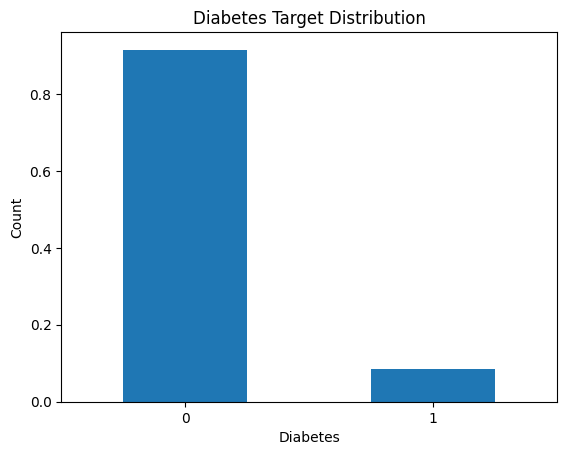

In [5]:
print(f"\nDiabetes Dataset Target Distribution Percentage:\n {diabetes_dataset['diabetes'].value_counts(normalize=True).plot(kind='bar')}")
plt.title('Diabetes Target Distribution')
plt.xlabel('Diabetes')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.plot
#plt.savefig('diabetes_model/diabetes_target_distribution.png')
plt.show()

In [6]:

unused_colms = []   # unused columns will be removed at later stage
target_col = ['diabetes']

numerical_features = []
categorical_features = []

for col in diabetes_dataset.columns:
    if col not in target_col + unused_colms:
        if diabetes_dataset[col].dtypes != 'object':
            numerical_features.append(col)
        else:
            categorical_features.append(col)


print('Number of numerical variables: {}'.format(len(numerical_features)),":" , numerical_features)

print('Number of categorical variables: {}'.format(len(categorical_features)),":" , categorical_features)

Number of numerical variables: 6 : ['age', 'hypertension', 'heart_disease', 'bmi', 'HbA1c_level', 'blood_glucose_level']
Number of categorical variables: 2 : ['gender', 'smoking_history']


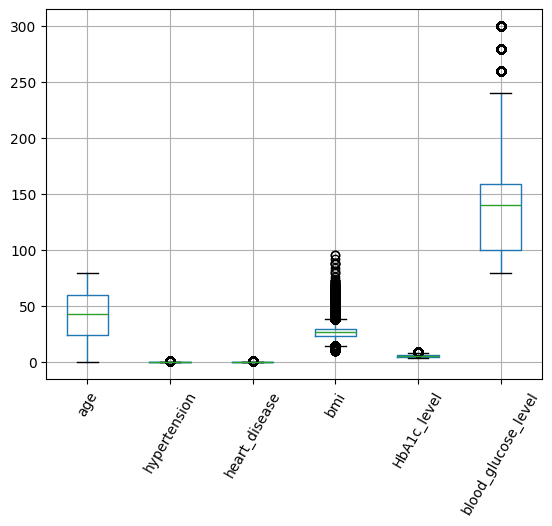

In [7]:
diabetes_dataset[numerical_features].boxplot()
plt.xticks(rotation= 60)
plt.show()

In [8]:
# The above shows the column BMI has many outliers, and looking at data it shows many rows with BMI over 40 which does not look realistic. 
# Should be dropped.
drop_columns = ['bmi']

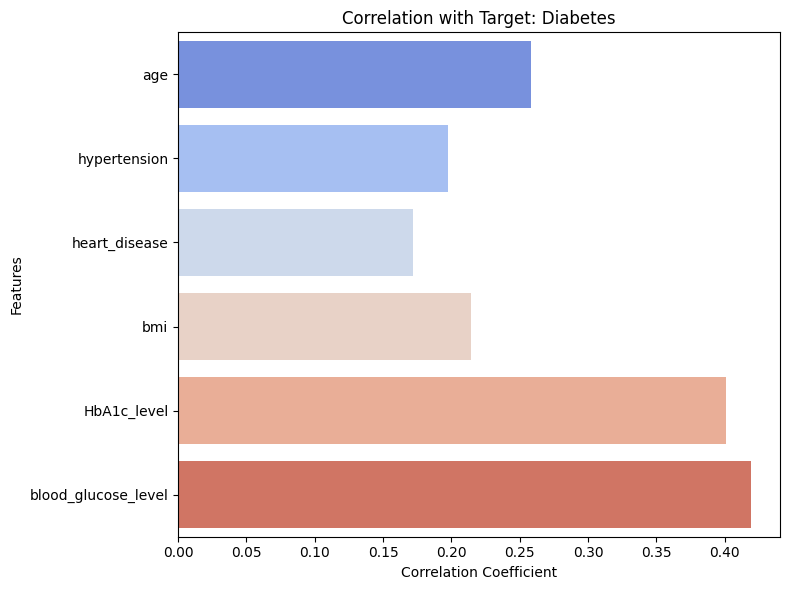

In [9]:
#Show correlation of diabetes to the other columns. Numeric ones only
target_corr = diabetes_dataset.corr(numeric_only=True)['diabetes'].drop('diabetes')
plt.figure(figsize=(8, 6))
sns.barplot(x=target_corr.values, y=target_corr.index, palette="coolwarm", 
           hue= target_corr.index,
           legend=False, 
           dodge=False)
plt.title("Correlation with Target: Diabetes")
plt.xlabel("Correlation Coefficient")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

In [10]:
diabetes_dataset.gender.unique()

array(['Female', 'Male', 'Other'], dtype=object)

In [11]:
diabetes_dataset.smoking_history.unique()

array(['never', 'No Info', 'current', 'former', 'ever', 'not current'],
      dtype=object)

In [12]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder

In [13]:
#Unmodified data
#data = pd.read_csv('../datasets/diabetes_prediction_dataset.csv')

In [14]:
class Mapper(BaseEstimator, TransformerMixin):
    """
    Ordinal categorical variable mapper:
    Treat column as Ordinal categorical variable, and assign values accordingly
    """

    # The mapping will contain the values to map
    #   - key is current categorical variable value
    #   - value is the integer value to replace with
    def __init__(self, variables: str, mappings: dict):

        if not isinstance(variables, str):
            raise ValueError("variables should be a str")

        self.variables = variables
        self.mappings = mappings

    def fit(self, X: pd.DataFrame, y: pd.Series = None):
        # we need the fit statement to accomodate the sklearn pipeline
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        X = X.copy()
        # Map the value and set the type as int
        X[self.variables] = X[self.variables].map(self.mappings).astype(int)

        return X

In [34]:
class SmokingOneHotEncoder(BaseEstimator, TransformerMixin):
    """ One-hot encode weekday column """

    def __init__(self, variables: str):
        # YOUR CODE HERE
        if not isinstance(variables, str):
            raise ValueError("variables should be a list")

        self.variables = variables

    def fit(self, X: pd.DataFrame, y: pd.Series = None):
        # YOUR CODE HERE
        self.encoder = OneHotEncoder(sparse_output=False)
        self.encoder.fit(X[[self.variables]])
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        # YOUR CODE HERE
        # Do the one shot encoding transformation
        encoded_smoking = self.encoder.transform(X[[self.variables]])

        # Get the encoded feature names
        enc_smoking_features = self.encoder.get_feature_names_out()
        #print(f"Feature:\n {enc_smoking_features}") 
        # Append encoded weekday features to X
        X[enc_smoking_features] = encoded_smoking
        
        return X


In [ ]:
smoking_encoder = SmokingOneHotEncoder('smoking_history')
diabetes_dataset = smoking_encoder.fit_transform(diabetes_dataset)

In [36]:
diabetes_dataset.head(3)


,gender,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,smoking_history_No Info,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current
0,0,80.0,0,1,25.19,6.6,140,0.0,0.0,0.0,0.0,1.0,0.0
1,0,54.0,0,0,27.32,6.6,80,1.0,0.0,0.0,0.0,0.0,0.0
2,1,28.0,0,0,27.32,5.7,158,0.0,0.0,0.0,0.0,1.0,0.0


In [20]:
class LabelEncoderTransformer(BaseEstimator, TransformerMixin):
    """ One-hot encode weekday column """

    def __init__(self, variables: str):
        # YOUR CODE HERE
        if not isinstance(variables, str):
            raise ValueError("variables should be a list")

        self.variables = variables

    def fit(self, X: pd.DataFrame, y: pd.Series = None):
        # YOUR CODE HERE
        self.encoder = LabelEncoder()
        #self.encoder.fit(X[[self.variables]])
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        # YOUR CODE HERE
        # Do the one shot encoding transformation
        X[self.variables] = self.encoder.fit_transform(X[self.variables])     

        return X


In [22]:
le = LabelEncoderTransformer('gender')
diabetes_dataset = le.fit_transform(diabetes_dataset)

In [23]:
diabetes_dataset.gender.unique()

array([0, 1, 2])

In [24]:
diabetes_dataset.drop(['smoking_history', 'diabetes'], axis=1, inplace=True)

In [25]:
diabetes_dataset.head(3)

,gender,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,smoking_history_No Info,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current
0,0,80.0,0,1,25.19,6.6,140,0.0,0.0,0.0,0.0,1.0,0.0
1,0,54.0,0,0,27.32,6.6,80,1.0,0.0,0.0,0.0,0.0,0.0
2,1,28.0,0,0,27.32,5.7,158,0.0,0.0,0.0,0.0,1.0,0.0


In [46]:
print (f"Gender : {diabetes_dataset.loc[75721, 'gender']}")
print (diabetes_dataset.loc[75721])

Gender : 0
gender                           0.00
age                             13.00
hypertension                     0.00
heart_disease                    0.00
bmi                             20.82
HbA1c_level                      5.80
blood_glucose_level            126.00
smoking_history_No Info          1.00
smoking_history_current          0.00
smoking_history_ever             0.00
smoking_history_former           0.00
smoking_history_never            0.00
smoking_history_not current      0.00
Name: 75721, dtype: float64


In [52]:
print (f"sample smoking: {diabetes_dataset.loc[75721, 'HbA1c_level']}")


sample smoking: 5.8
